In [1]:
import os
import textwrap

import numpy as np
import pandas as pd

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from confusion_matrix import calc_confusion_matrix_for_probas_and_threshold


In [2]:
# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', style='whitegrid', font_scale=1.25)

# Autoload changes in other files.
# Avoids restarting the Jupyter kernel each time you make a change to the imported code.
%load_ext autoreload
%autoreload 2

In [3]:
# Reading in training data
data_dir = "data_readinglevel"
x_train_df = pd.read_csv(os.path.join(data_dir, "x_train.csv"))
y_train_df = pd.read_csv(os.path.join(data_dir, "y_train.csv"))

N, n_cols = x_train_df.shape
print("Shape of x_train_df: (%d, %d)" % (N, n_cols))
print("Shape of y_train_df: %s" % str(y_train_df.shape))

y_train_N = []
for curr_line in y_train_df['Coarse Label']:
    if curr_line == "Key Stage 2-3":
        y_train_N.append(0)
    elif curr_line == "Key Stage 4-5":
        y_train_N.append(1)
    else:
        raise Exception("incorrect formatted y_train.csv")
    
print(f"columns are {x_train_df.columns}")

# TODO: For all of x_train_df, find the frequencies of each word. 
    # Literally just copy from lab\
corpus_N = []
sentiments_N = []
# all_texts_as_line_separated_string = ""
# TODO: assuming the vectorize thing works, uncomment this line and remove this 
for curr_line in x_train_df['text']:
    # all_texts_as_line_separated_string += (curr_line + '\n')
    corpus_N.append(curr_line)
    
for curr_line2 in x_train_df['sentiment_polarity']:
    sentiments_N.append(curr_line2)

from sklearn.model_selection import train_test_split

y_N = np.asarray(y_train_N)

corpus_M, corpus_test_P, y_train_M, y_test_P = train_test_split(corpus_N, y_N, test_size=0.2, random_state=2048, stratify=y_N)

assert len(y_train_M) == len(corpus_M)
assert len(corpus_test_P) == len(y_test_P)

P = len(corpus_test_P)

yhat_baseline_N = np.zeros(N)
yhat_baseline_P = np.zeros(P)
# Print out 8 random entries
# tr_text_list = x_train_df["text"].values.tolist()
# prng = np.random.RandomState(101)
# rows = prng.permutation(np.arange(y_train_df.shape[0]))
# for row_id in rows[:8]:
#     text = tr_text_list[row_id]
#     print(
#         "row %5d | %s BY %s | y = %sx_train_df['text']"
#         % (
#                 y_train_df["title"].values[row_id],
#             y_train_df["author"].values[row_id],
#             y_train_df["Coarse Label"].values[row_id],
#         )
#     )
#     # Pretty print text via textwrap library
#     line_list = textwrap.wrap(
#         tr_text_list[row_id], width=70, initial_indent="  ", subsequent_indent="  "
#     )
#     print("\n".join(line_list))
#     print("")
#     print("")
# print(all_texts_as_line_separated_string)

Shape of x_train_df: (5557, 32)
Shape of y_train_df: (5557, 5)
columns are Index(['author', 'title', 'passage_id', 'text', 'char_count', 'word_count',
       'sentence_count', 'avg_word_length', 'avg_sentence_length',
       'type_token_ratio', 'pronoun_freq', 'function_words_count',
       'punctuation_frequency', 'sentiment_polarity', 'sentiment_subjectivity',
       'readability_Kincaid', 'readability_ARI', 'readability_Coleman-Liau',
       'readability_FleschReadingEase', 'readability_GunningFogIndex',
       'readability_LIX', 'readability_SMOGIndex', 'readability_RIX',
       'readability_DaleChallIndex', 'info_characters_per_word',
       'info_syll_per_word', 'info_words_per_sentence',
       'info_type_token_ratio', 'info_characters', 'info_syllables',
       'info_words', 'info_wordtypes'],
      dtype='object')


In [4]:
# v = CountVectorizer(min_df=4, stop_words='english')
# x_NF = v.fit_transform(corpus)
# N, F = x_NF.shape

# print(v.vocabulary_)
# print(f"x_NF shape : {x_NF.shape}")


In this following section, we now implement Grid Search to test out a variety of different parameters. 

In [5]:
# print(np.logspace(0, 10, num=11, dtype=np.int32))
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline


print(np.logspace(-4,4,num=9))
prng = np.random.RandomState(888)
print(f"Logspace: {np.logspace(2, 5, endpoint=True, num=10, dtype=np.int64)} ")






[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
Logspace: [   100    215    464   1000   2154   4641  10000  21544  46415 100000] 


In [6]:
# Generating the hyper parameters that we will search through

grid = dict()
Cs = np.logspace(-4,4,num=9)
# Cs = np.logspace(-3,0,num=10)
grid['trainer__C'] = Cs
print(f"trainer__C in the following range: {Cs}")
max_feats = np.logspace(2,4, endpoint=True, num=10, dtype=np.int64)
grid['tokenizer__max_features'] = max_feats
print(f"tokenizer__max_features in the following range: {max_feats} ")


trainer__C in the following range: [1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
tokenizer__max_features in the following range: [  100   166   278   464   774  1291  2154  3593  5994 10000] 


In [7]:
# problem: we want a lot of features, but want to avoid models that have a lot
# of features BUT a very small C

def remove_overfitting_hyperparams(cv_results):
    cv_results_ = pd.DataFrame(cv_results)
    low_trainer_Cs_results = cv_results_[cv_results_['param_trainer__C'] < 1.]
    return np.min(low_trainer_Cs_results['rank_test_score'])

In [8]:
temp__max_feats = []
for _ in range(10):
    temp__corpus_M, _, _, _ = train_test_split(corpus_N, y_N, test_size=0.2, random_state=None, stratify=y_N)

    temp__max_feats.append(CountVectorizer(stop_words='english', min_df=4, strip_accents='unicode').fit_transform(temp__corpus_M).shape[1])

temp__max_feats

[6336, 6375, 6407, 6386, 6390, 6362, 6359, 6323, 6315, 6344]

In [9]:

# creating the greatest fit of all time 😼!!!!
steps = [('tokenizer', CountVectorizer(stop_words='english', min_df=4, strip_accents='unicode',ngram_range=(1,3))),
         ('trainer', LogisticRegression(fit_intercept=True, penalty='l2', solver='lbfgs', n_jobs=-1, max_iter=1000))]
# chosen_scoring = 'accuracy'
# chosen_scoring = 'roc_auc'
chosen_scoring = ['roc_auc', 'neg_log_loss']
pipeline = Pipeline(steps)
n_folds = 10
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=72)

g = GridSearchCV(pipeline, grid, 
                 scoring=chosen_scoring, 
                 cv=folds, 
                 n_jobs=-1,
                 refit='roc_auc',
                 return_train_score=True,
                # refit=True,
                #  refit=remove_overfitting_hyperparams,
                 verbose=0) # FIXME for output

g.fit(corpus_M, y_train_M)


print('F', F := len(g.best_estimator_.named_steps['tokenizer'].vocabulary_))
# print(f'F   {F}')
print("done")

F 7162
done


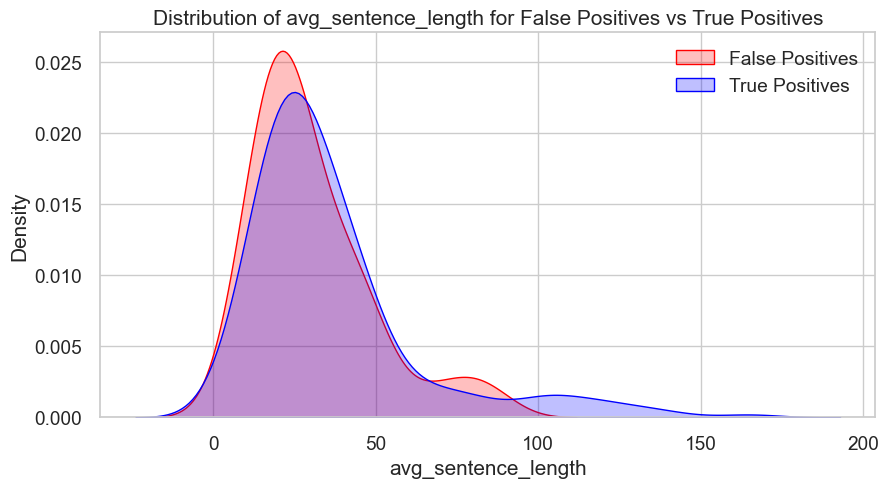

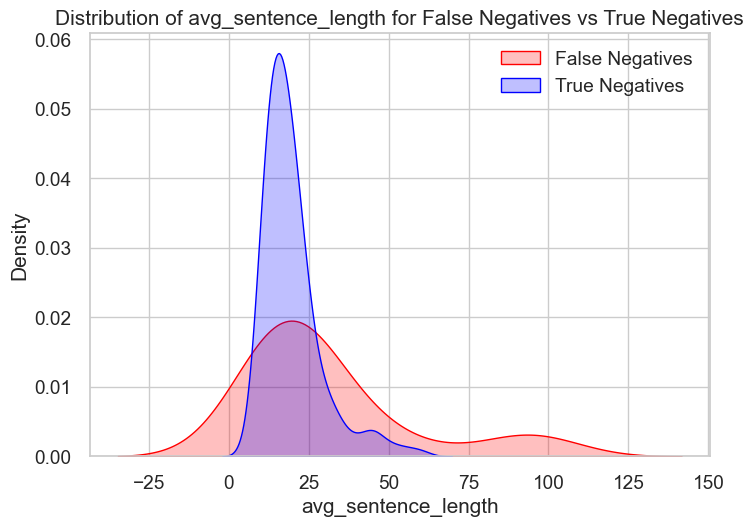

In [42]:
# report 1D

from sklearn.metrics import confusion_matrix


best_index = np.argmax(g.cv_results_["mean_test_roc_auc"])

best_fold = np.argmax([g.cv_results_[f'split{i}_test_roc_auc'][best_index] for i in range(n_folds)])

best_estimator = g.best_estimator_

cmats = []
x_val_dfs = []
val_idxs = []
y_val_dfs = []
yhat_val_dfs = []
# disregard train_idx
count = 0
for _, val_idx in folds.split(corpus_M, y_train_M):
        
    x_val_df = np.asarray(corpus_N)[val_idx]
    y_val_df = np.asarray(y_N)[val_idx]

    x_val_dfs.append(x_val_df)
    y_val_dfs.append(y_val_df)
    
    yhat_val_df = best_estimator.predict_proba(x_val_df)[:,1]
    
    yhat_val_dfs.append(yhat_val_df)
    
    cmats.append(calc_confusion_matrix_for_probas_and_threshold(y_val_df, yhat_val_df, 0.5))
    count += 1
    val_idxs.append(val_idx)
# print(cmats[4].to_latex()) # chosen arbitrarily

chosen_idx = 4

chosen_xs = x_val_dfs[chosen_idx]
chosen_ys = y_val_dfs[chosen_idx]
chosen_yhats = yhat_val_dfs[chosen_idx]
chosen_cmat = cmats[chosen_idx]
chosen_vals = val_idxs[chosen_idx]

mu = np.mean(np.vectorize(len)(chosen_xs))
sigma = np.std(np.vectorize(len)(chosen_xs))

# print(f'(mu, sigma)   {(mu, sigma)}')


chosen_preds = (chosen_yhats >= 0.5).astype(int)
incorrect_idxs = np.where(chosen_preds != chosen_ys)[0]

fns = np.where((chosen_preds == 0) & (chosen_ys == 1))[0]
tns = np.where((chosen_preds == 0) & (chosen_ys == 0))[0]
fps = np.where((chosen_preds == 1) & (chosen_ys == 0))[0]
tps = np.where((chosen_preds == 1) & (chosen_ys == 1))[0]

assert len(tps) == 214



tnxs = chosen_xs[tns]
fnxs = chosen_xs[fns]
fpxs = chosen_xs[fps]
tpxs = chosen_xs[tps]
wrongxs = chosen_xs[incorrect_idxs]
wrongys = chosen_ys[incorrect_idxs]

# wrong__len_mu = np.mean(np.vectorize(len)(wrongxs))
# wrong__lensigma = np.std(np.vectorize(len)(wrongxs))

# print(f'wrongmu, wrongsigma   {wrong__len_mu, wrong__lensigma}')


fn_idxs = x_train_df[x_train_df['text'].isin(fnxs)].index
tn_idxs = x_train_df[x_train_df['text'].isin(tnxs)].index
fp_idxs = x_train_df[x_train_df['text'].isin(fpxs)].index
tp_idxs = x_train_df[x_train_df['text'].isin(tpxs)].index


# wrong_idxs = x_train_df[x_train_df['text'].isin(wrongxs)].index

# METRIC = 'sentiment_polarity'
# METRIC = 'word_count'
# METRIC = 'readability_DaleChallIndex'
# METRIC = 'function_words_count'
# METRIC = 'pronoun_freq'
# METRIC = 'readability_GunningFogIndex'
# METRIC = 'avg_word_length'
METRIC = 'avg_sentence_length'
# METRIC = 'readability_LIX'
# METRIC = 'author'

tp_metrics = x_train_df.loc[tp_idxs, METRIC]
tn_metrics = x_train_df.loc[tn_idxs, METRIC]
fp_metrics = x_train_df.loc[fp_idxs, METRIC]
fn_metrics = x_train_df.loc[fn_idxs, METRIC]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# Plot histogram with KDE
sns.kdeplot(fp_metrics, label="False Positives", fill=True, color="red")
sns.kdeplot(tp_metrics, label="True Positives", fill=True, color="blue")

plt.xlabel(f"{METRIC}")
plt.ylabel("Density")
plt.title(f"Distribution of {METRIC} for False Positives vs True Positives")
plt.legend()
plt.show()


sns.kdeplot(fn_metrics, label="False Negatives", fill=True, color="red")
sns.kdeplot(tn_metrics, label="True Negatives", fill=True, color="blue")

plt.xlabel(f"{METRIC}")
plt.ylabel("Density")
plt.title(f"Distribution of {METRIC} for False Negatives vs True Negatives")
plt.legend()
plt.show()


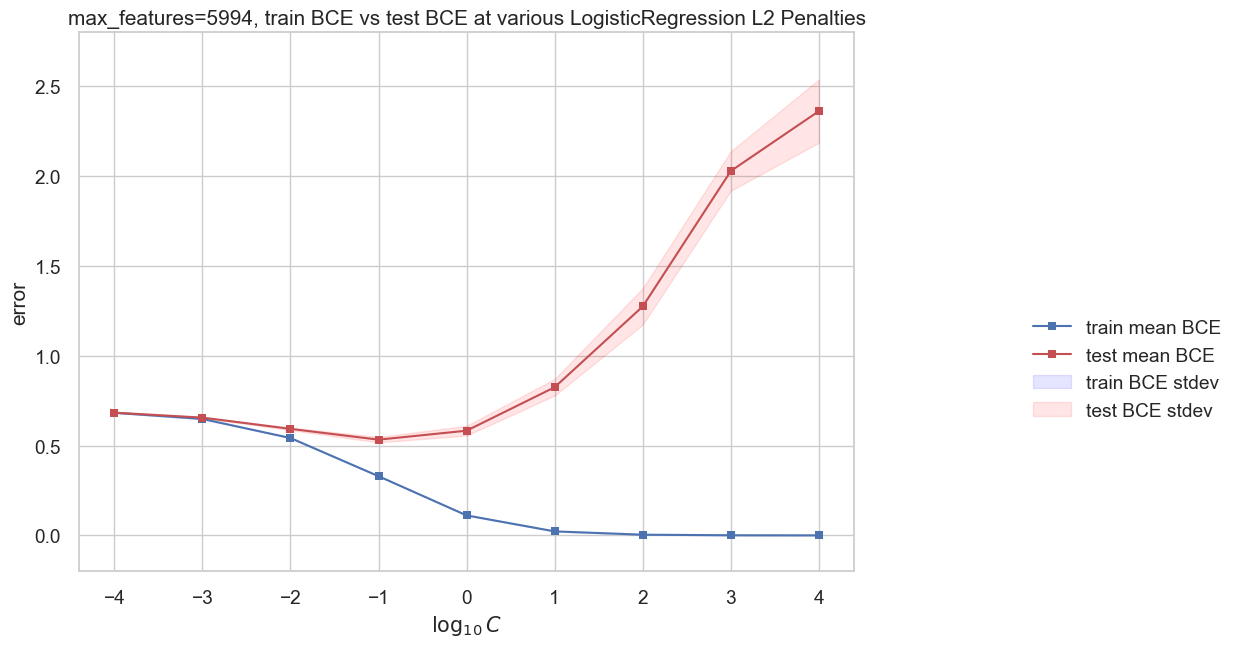

In [ ]:
# train vs test error
# report 1C

# holding max feats constant

best_model = g.best_estimator_

max_features_values = max_feats
C_values = Cs

C_grid, max_feats_grid = np.meshgrid(C_values, max_features_values)

fig = plt.figure(figsize=(10,7))

gsearch_results_df = pd.DataFrame(g.cv_results_.copy())

fixed_mfs__df = []

for mf in max_features_values:
    subset = gsearch_results_df[gsearch_results_df['param_tokenizer__max_features'] == mf]
    sorted_subset = subset.sort_values(by='param_trainer__C')
    
    fixed_mfs__df.append(sorted_subset)
    
    
for mf in range(len(fixed_mfs__df)):
    if mf != 8:
        continue
    x_axis = fixed_mfs__df[mf]['param_trainer__C']
    y_train_axis = -1.0 * fixed_mfs__df[mf]['mean_train_neg_log_loss']
    sigma_train_axis = fixed_mfs__df[mf]['std_train_neg_log_loss']
    y_test_axis = -1.0 * fixed_mfs__df[mf]['mean_test_neg_log_loss']
    sigma_test_axis = fixed_mfs__df[mf]['std_test_neg_log_loss']
    
    assert np.all(sigma_test_axis > 0)
    assert np.all(sigma_train_axis > 0)

    



    plt.plot(np.log10(x_axis), y_train_axis, 'bs-', label='train mean BCE')
    plt.plot(np.log10(x_axis), y_test_axis, 'rs-', label='test mean BCE')
    
    plt.fill_between(np.log10(x_axis), y_train_axis 3- sigma_train_axis, 
                     y_train_axis + sigma_train_axis,
                     color='blue',
                     alpha=0.1,
                     label='train BCE stdev ')
    plt.fill_between(np.log10(x_axis), y_test_axis - sigma_test_axis, 
                     y_test_axis + sigma_test_axis,
                     color='red',
                     alpha=0.1,
                     label='test BCE stdev ')

    plt.ylabel('error')
    plt.xlabel("$\log_{10} C$")
    plt.title(f"max_features={max_features_values[mf]}, train BCE vs test BCE at various LogisticRegression L2 Penalties")
    plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
    if mf > 7:
        plt.ylim([-0.2, 2.8]);
    else:
        plt.ylim([0.5, 0.8]);
    plt.show()


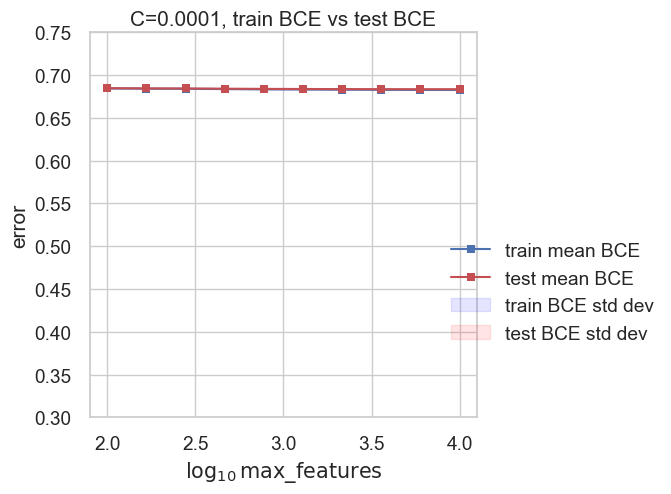

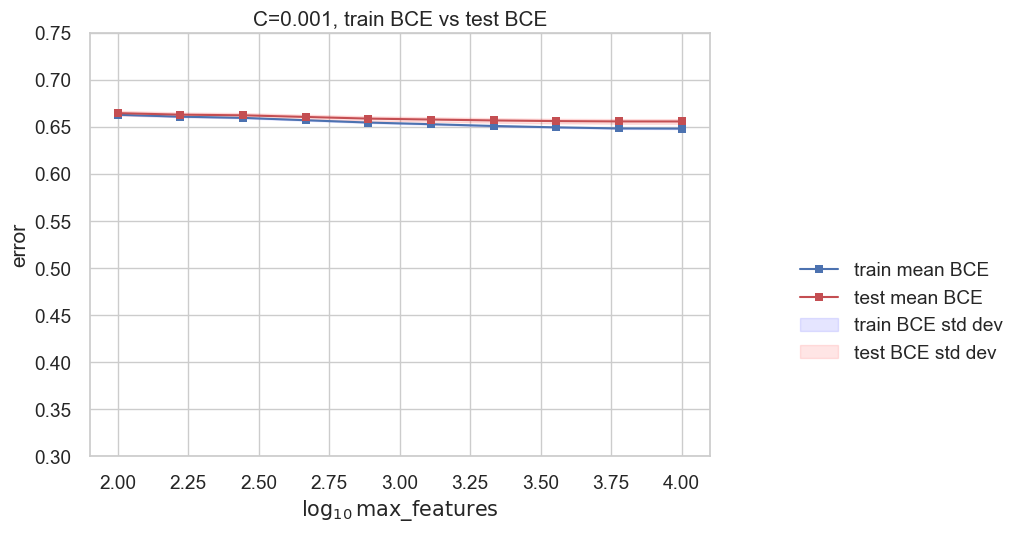

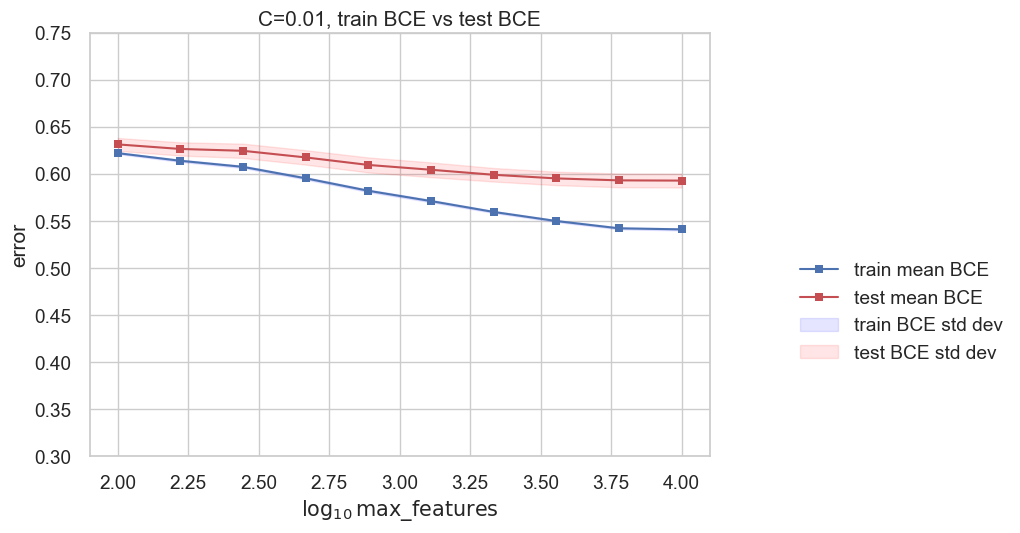

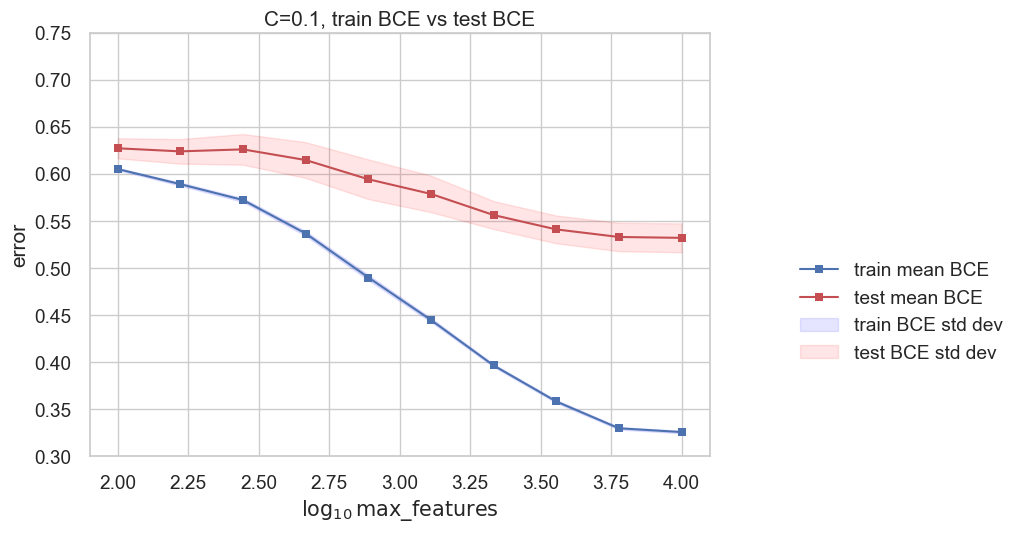

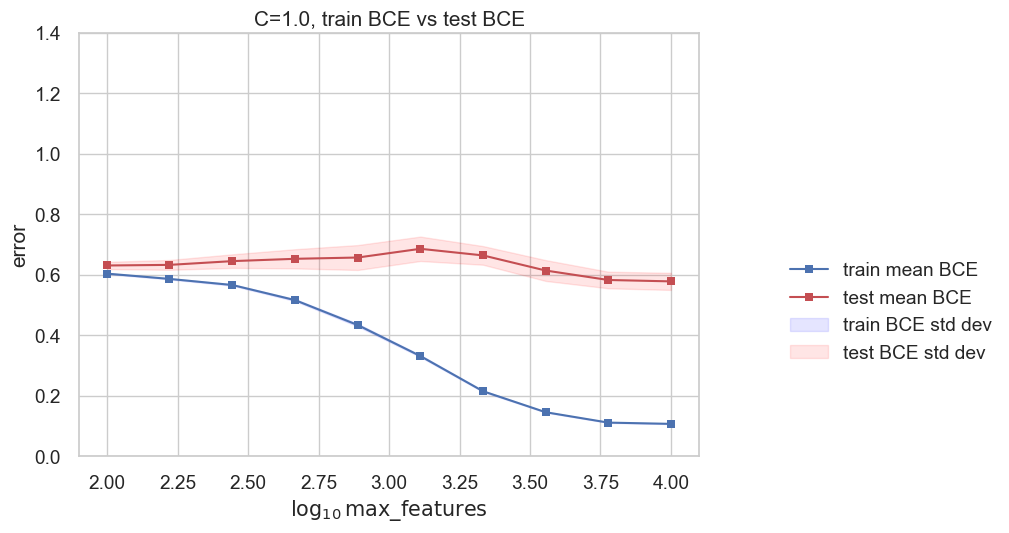

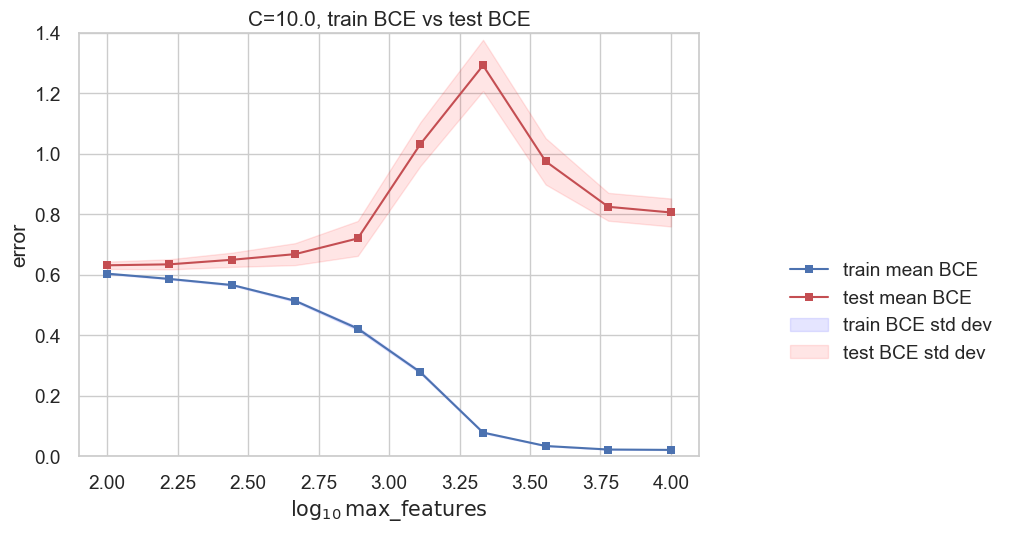

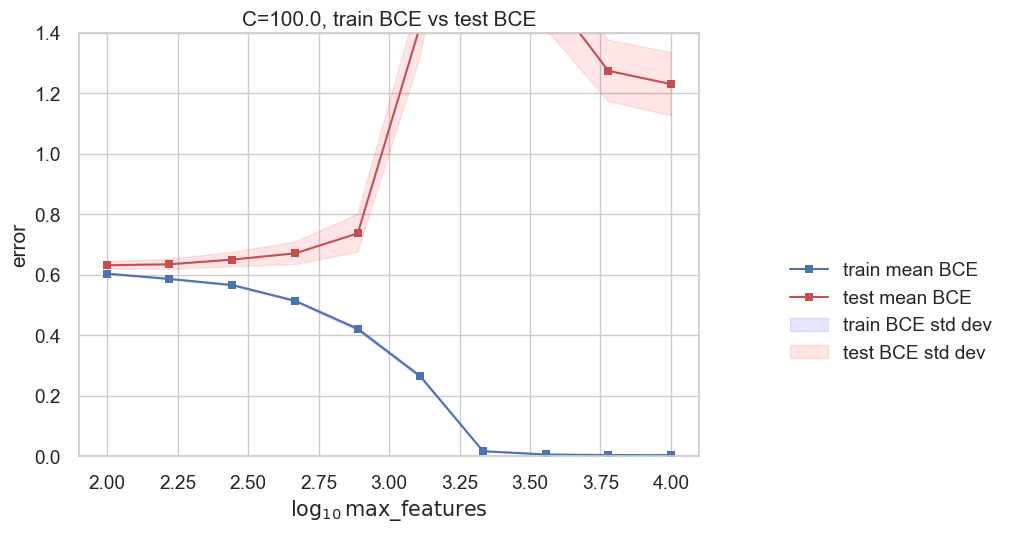

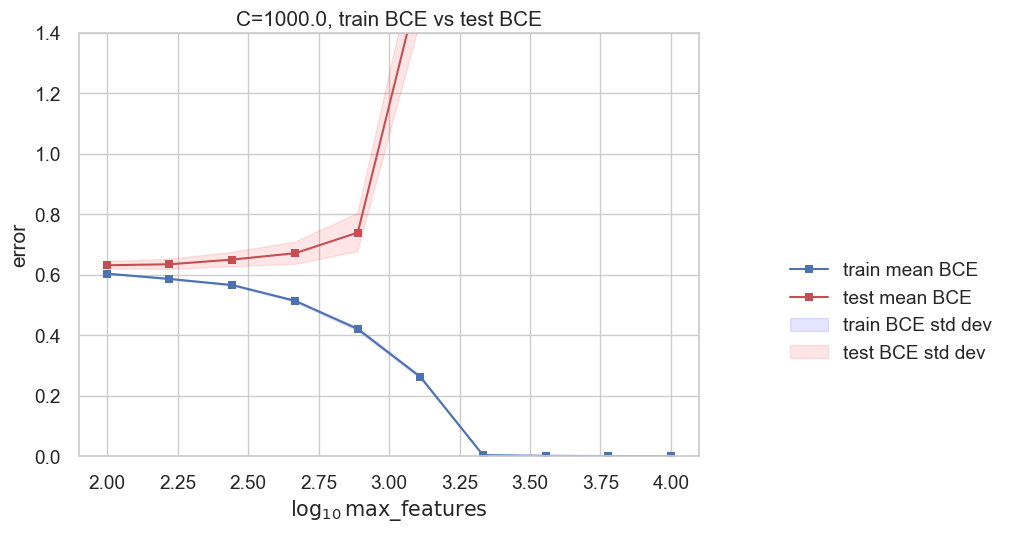

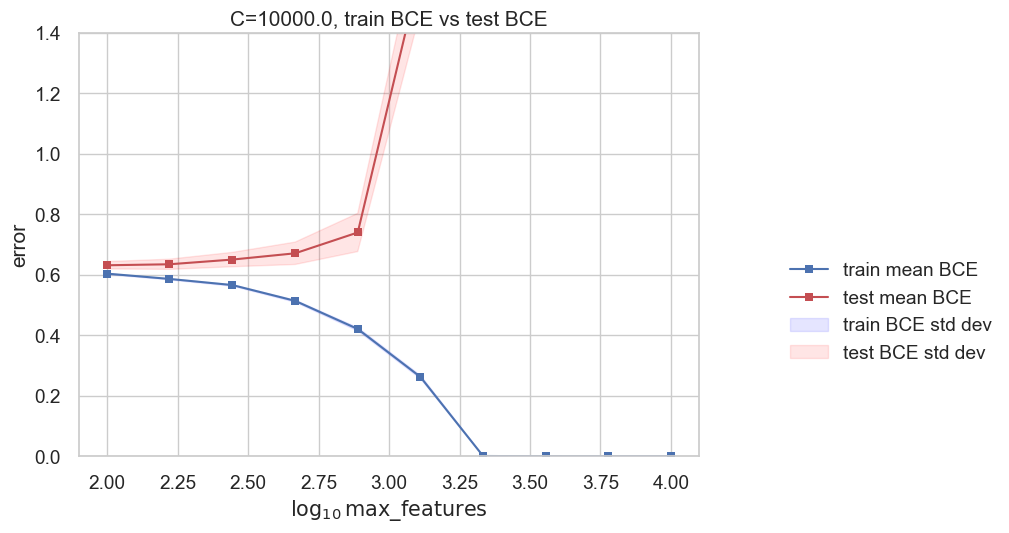

In [149]:

# train vs test error
# report 1C

# holding Cs fixed


import matplotlib.pyplot as plt


plt.subplots(nrows=1, ncols=1, figsize=(5,5));

best_model = g.best_estimator_

gsearch_results_df = pd.DataFrame(g.cv_results_).copy()

Cs

fixed_Cs__df = []

for cc in Cs:
    subset = gsearch_results_df[gsearch_results_df['param_trainer__C'] == cc]
    sorted_subset = subset.sort_values(by='param_tokenizer__max_features')
    
    fixed_Cs__df.append(sorted_subset)
    
    
    
for cc in range(len(fixed_Cs__df)):
    x_axis = fixed_Cs__df[cc]['param_tokenizer__max_features']
    y_train_axis = -1.0 * fixed_Cs__df[cc]['mean_train_neg_log_loss']
    y_test_axis = -1.0 * fixed_Cs__df[cc]['mean_test_neg_log_loss']
    sigma_train_axis = fixed_Cs__df[cc]['std_train_neg_log_loss']
    sigma_test_axis = fixed_Cs__df[cc]['std_test_neg_log_loss']


    plt.plot(np.log10(x_axis), y_train_axis, 'bs-', label='train mean BCE')
    plt.plot(np.log10(x_axis), y_test_axis, 'rs-', label='test mean BCE')
    
    plt.fill_between(np.log10(x_axis), y_train_axis - sigma_train_axis, 
                     y_train_axis + sigma_train_axis,
                     color='blue', alpha=0.1, label='train BCE std dev')
    
    plt.fill_between(np.log10(x_axis), y_test_axis - sigma_test_axis, 
                     y_test_axis + sigma_test_axis,
                     color='red', alpha=0.1, label='test BCE std dev')
    plt.ylabel('error')
    plt.xlabel("$\log_{10} \\text{max_features}$")
    plt.title(f"C={Cs[cc]}, train BCE vs test BCE")
    plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
    if cc > 3:
        plt.ylim([0, 1.4]);
    else:
        plt.ylim([0.3, 0.75]);
    plt.show()


In [32]:
# NEW calcing heldout error on TEST data (never seen before)
yhat_proba_P = g.predict_proba(corpus_test_P)[:,1]



# best_model = g.best_estimator_
# yhat_long_N = best_model.predict_proba(x_N)[:,1]
print(calc_confusion_matrix_for_probas_and_threshold(y_test_P, yhat_proba_P, 0.5).to_latex())
# g.best_score_






\begin{tabular}{lrr}
\toprule
Predicted & 0 & 1 \\
True &  &  \\
\midrule
0 & 313 & 189 \\
1 & 120 & 490 \\
\bottomrule
\end{tabular}



## predict-0-always baseline


baseline__AUROC, GridSearchCV__AUROC (0.5, 0.7899026843445889)


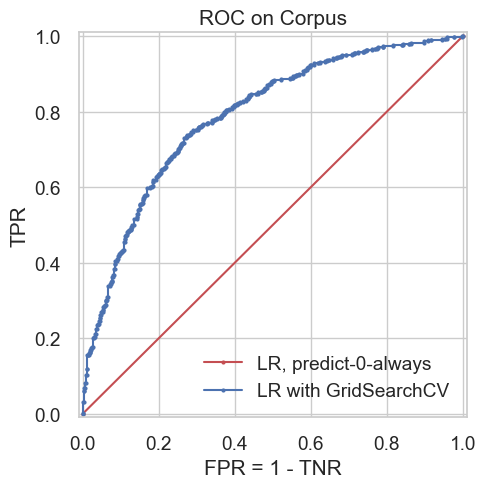

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve

plt.subplots(nrows=1, ncols=1, figsize=(5,5));

# Create ROC curve for predict-0-always baseline
fpr, tpr, t2 = roc_curve(y_test_P, yhat_baseline_P)
baseline__AUROC = roc_auc_score(y_test_P, yhat_baseline_P)
plt.plot(fpr, tpr, 'r.-', label='LR, predict-0-always')



# Create ROC curve for pipeline
fpr, tpr, t2 = roc_curve(y_test_P, yhat_proba_P)
# NOTE: this is shittily named. baseline__GridSearchCV is really just the AUROC for our best looker.
GridSearchCV__AUROC = roc_auc_score(y_test_P, yhat_proba_P)
plt.plot(fpr, tpr, 'b.-', label='LR with GridSearchCV')


# Formatting
plt.title("ROC on Corpus");
plt.xlabel('FPR = 1 - TNR');
plt.ylabel('TPR');
plt.legend(loc='lower right');
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);
print(f'baseline__AUROC, GridSearchCV__AUROC {baseline__AUROC, GridSearchCV__AUROC}')

In [152]:
import sklearn.metrics


# print(sklearn.metrics.zero_one_loss(y_N, yhat_proba_N))
g.best_params_

# yhat_proba_N

{'tokenizer__max_features': 10000, 'trainer__C': 0.1}

In [153]:


x_train_df = pd.read_csv(os.path.join(data_dir, "x_test.csv"))

x_test_P = [curr_line for curr_line in x_train_df['text']]

y_test_P = g.best_estimator_.predict_proba(x_test_P)[:,1]
y_test_df = pd.DataFrame(y_test_P)
y_test_df.to_csv('yproba1_test.txt',index=False, header=False, sep='\n')

s = np.loadtxt('yproba1_test.txt')
s.shape


(1197,)